# PID controller with a brake

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
b1, b2, b3, b4, s0, s1, s2 = ?

while(t < T):

    # decides whether brake is needed
    if b1*d+b2>0 and b3*d+4>0 {
        brakev = -1
    } else {
        brakev = 1
    }

    d = ang - 3.14
    torq = s0 *  d + s1 * v + s2 * id + brakev + gauss(0, 0.5);
    id = 0.9*id + d
    oldv= v 

    v = v + 0.01*torq + gauss(0, 0.5)
    ang = ang + 0.05*(v + oldv) + gauss(0, 0.1)

    if ang > 6.28 {
        ang = ang - 6.28
    } elif ang < 0 {
        ang = and + 6.28
    }  
```

In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

### Original Model

In [144]:
target = 3.14
dt = 0.1
inertia = 10
decay = 0.9


def orig_model(T=50, init_ang = 0.5, b1=-1, b2=-2, b3=1, b4=-6, s0=1, s1=1, s2=1):
    
    traj = torch.zeros(T)

    smoothing = distributions.Normal(torch.tensor(0.), torch.tensor(0.05))
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(0.25))
    noise_ang = distributions.Normal(torch.tensor(0.), torch.tensor(0.25))

    v = 0 #+ smoothing.rsample()
    ang = init_ang #+ smoothing.rsample()
    id = 0 #+ smoothing.rsample()
    old_v = 0 #+ smoothing.rsample()

    for i in range(0,T):

        traj[i] = ang #+ smoothing.rsample()
        
        d = target - ang #+smoothing.rsample()
        torq = s0*d + s1*v + s2*id #+ smoothing.rsample() # + brakev
        id = decay*id + d*dt
        oldv = v #+ smoothing.rsample()
        
        v = v + (dt/inertia)*torq + noise.rsample()
        ang = ang + (dt/2)*(v+oldv) + noise_ang.rsample()
        
        #if b1*d+b2>0 and b2*d+b4>0:
        #    brakev = -1
        #else:
        # brakev = 1        
        
        #if ang > 6.28:
        #    ang = ang - 6.28
        #elif ang < 0:
        #    ang = ang + 6.28

    traj[T-1] = ang #+ smoothing.rsample()

    return traj        

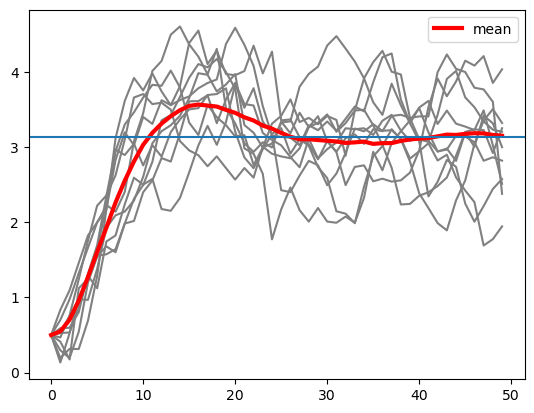

In [145]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

T = 50
s0 = 46
s1 = -23
s2 = 0
init_ang = 0.5

traj_set = []
for _ in range(500):
    traj_set.append(orig_model(T, init_ang, s0=s0, s1=s1, s2=s2))
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(T), traj_set[i], color='grey')

plt.plot(range(T), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.axhline(y=target)
plt.legend()

### SOGA program

In [155]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [156]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/PID.soga')
cfg = produce_cfg(compiledFile)

pars = {'s0':46., 's1':-23., 's2':0.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

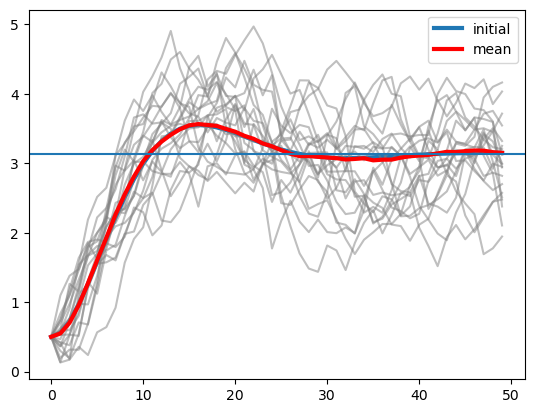

In [157]:
import matplotlib.pyplot as plt

T = 50
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(20):
    plt.plot(range(T), traj_set[i], color='grey', alpha=0.5)

plt.plot(range(T), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.axhline(y=target)

plt.legend()

In [158]:
def neg_log_likelihood(traj_set, dist):
    idx = list(range(1,20))
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[i, 1:], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = list(range(1,T))
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

def signal_error(dist, target=3.14, eps=0.1, T=50):
    idx = list(range(1,T))
    target_signal = target*torch.ones(len(idx))
    return torch.sum(torch.pow(dist.gm.mean()[idx] - target_signal, 2))

signal_error(output_dist)

tensor(27.2889, grad_fn=<SumBackward0>)

In [ ]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    
    optimizer.zero_grad()  # Reset gradients
    
    #with torch.autograd.set_detect_anomaly(True):
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = signal_error(current_dist)
        
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

s0: 46.04999923706055 s1: -23.049999237060547 s2: -0.049999989569187164  loss: 27.288877487182617
s0: 48.53888702392578 s1: -23.684314727783203 s2: -2.3729732036590576  loss: 26.310205459594727


In [ ]:
params_dict

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/PID.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA(cfg, params_dict)

In [ ]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
#for i in range(20):
#    plt.plot(range(T), traj_set[i], color='grey')

plt.plot(range(T), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(T), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='optimized model')

plt.axhline(y=target)


plt.legend()